In [1]:
# GO Enrichment Analysis for Hypnoidus abbreviatus

In [2]:
# Import Library
import pandas as pd

In [4]:
# Note: Locate the eggNOG-mapper output from the results folder. Then follow this step:

# Load eggNOG output
df = pd.read_csv("Haab_EggNOG_result.csv", low_memory=False)

In [5]:
df.head(2) # View the top 2 data column

,#query,seed_ortholog,evalue,score,eggNOG_OGs,max_annot_lvl,COG_category,Description,Preferred_name,GOs,...,KEGG_ko,KEGG_Pathway,KEGG_Module,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,PFAMs
0,Habb_00001.p1,7070.TC007466-PA,7.580000e-296,826.0,"COG1131@1|root,KOG0061@2759|Eukaryota,38CVQ@33...",33208|Metazoa,Q,ATP- binding,-,"GO:0003674,GO:0003824,GO:0005215,GO:0005319,GO...",...,-,-,-,-,-,-,-,-,-,"ABC2_membrane,ABC_tran"
1,Habb_00001.p3,7070.TC007466-PA,3.860000e-54,186.0,"COG1131@1|root,KOG0061@2759|Eukaryota,38CVQ@33...",33208|Metazoa,Q,ATP- binding,-,"GO:0003674,GO:0003824,GO:0005215,GO:0005319,GO...",...,-,-,-,-,-,-,-,-,-,ABC2_membrane


In [6]:
# Rename for consistency
df = df.rename(columns={"#query": "query"})

In [7]:
# Keep only relevant columns and drop missing values
go_annotations = df[["query", "GOs"]].dropna()

# Expand comma-separated GO terms
go_annotations["GOs"] = go_annotations["GOs"].str.split(",")
go_annotations = go_annotations.explode("GOs")

In [8]:
import re

In [9]:
# Clean query names (remove .p1, .p3, .pe etc.)
go_annotations["gene"] = go_annotations["query"].apply(lambda x: re.sub(r"\.p\d+$|\.pe$", "", x))

In [10]:
# Drop duplicate gene-GO pairs
go_annotations = go_annotations[["gene", "GOs"]].drop_duplicates()
go_annotations = go_annotations.rename(columns={"GOs": "go_id"})

In [11]:
len(go_annotations)

2826876

In [12]:
go_annotations

,gene,go_id
0,Habb_00001,GO:0003674
0,Habb_00001,GO:0003824
0,Habb_00001,GO:0005215
0,Habb_00001,GO:0005319
0,Habb_00001,GO:0005575
...,...,...
27623,Habb_99978,GO:0072657
27623,Habb_99978,GO:0090150
27623,Habb_99978,GO:0097159
27623,Habb_99978,GO:1901363


In [13]:
go_annotations = go_annotations[go_annotations['go_id'] != '-'] # Remove "-"

In [14]:
len(go_annotations)

2819658

In [15]:
go_annotations

,gene,go_id
0,Habb_00001,GO:0003674
0,Habb_00001,GO:0003824
0,Habb_00001,GO:0005215
0,Habb_00001,GO:0005319
0,Habb_00001,GO:0005575
...,...,...
27623,Habb_99978,GO:0072657
27623,Habb_99978,GO:0090150
27623,Habb_99978,GO:0097159
27623,Habb_99978,GO:1901363


In [16]:
# Import libraries from GOATOOLS
from goatools.obo_parser import GODag
from tqdm import tqdm

In [17]:
# Load GO DAG (download if needed from http://purl.obolibrary.org/obo/go/go-basic.obo)
obodag = GODag("go-basic.obo")

go-basic.obo: fmt(1.2) rel(2025-03-16) 43,544 Terms


In [18]:
# Function to map GO terms and check if they are leaf (child) terms
def get_go_term_info(go_id):
    term = obodag.get(go_id)
    if term:
        return pd.Series({
            "term_name": term.name,
            "namespace": term.namespace,
            "parents": [p.id for p in term.parents] or [go_id],
            "all_parents": list(term.get_all_parents()) or [go_id],
            "is_leaf": len(term.children) == 0,    # True if it has no children
            "depth": term.level                    # Distance from the root (higher = more specific)
        })
    # If GO ID is not found in ontology
    return pd.Series({
        "term_name": None,
        "namespace": None,
        "parents": [],
        "all_parents": [],
        "is_leaf": False,
        "depth": None
    })

In [19]:
# Apply annotation function to GO terms
tqdm.pandas()
go_info = go_annotations["go_id"].progress_apply(get_go_term_info)

100%|██████████████████████████████████████████████████████████████████████| 2819658/2819658 [10:50<00:00, 4337.36it/s]


In [20]:
# Combine original annotations with GO metadata
df_go = pd.concat([go_annotations, go_info], axis=1)

In [21]:
# Strategy 1: Keep only child/leaf terms (no children)
df_leaf_terms = df_go[df_go["is_leaf"] == True]

In [22]:
# Strategy 2: Keep only functionally specific terms (depth ≥ 3)
df_specific_terms = df_go[df_go["depth"] >= 3]

In [23]:
# Strategy 3 (Recommended): Leaf terms that are also specific
df_specific_leaf_terms = df_go[(df_go["is_leaf"] == True) & (df_go["depth"] >= 3)]

In [24]:
# Summarize the most informative terms
go_counts = (
    df_specific_leaf_terms
    .groupby(["go_id", "term_name", "namespace", "depth"])
    .size()
    .reset_index(name="count")
    .sort_values(by=["count", "depth"], ascending=[False, False])
)

In [25]:
go_counts

,go_id,term_name,namespace,depth,count
3276,GO:0031981,nuclear lumen,cellular_component,5.0,5551
1649,GO:0007399,nervous system development,biological_process,4.0,4434
1236,GO:0005739,mitochondrion,cellular_component,5.0,2582
3485,GO:0032989,cellular anatomical entity morphogenesis,biological_process,4.0,2416
1657,GO:0007417,central nervous system development,biological_process,4.0,1724
...,...,...,...,...,...
7986,GO:1905394,retromer complex binding,molecular_function,3.0,1
8031,GO:1905761,SCF ubiquitin ligase complex binding,molecular_function,3.0,1
8112,GO:1990236,proteasome core complex import into nucleus,biological_process,3.0,1
8155,GO:1990435,upper tip-link density,cellular_component,3.0,1


In [26]:
# Remove 'go-id' that are less than 20 from the 'count' column
go_counts_filtered = go_counts[go_counts["count"] >= 20]

In [27]:
go_counts_filtered

,go_id,term_name,namespace,depth,count
3276,GO:0031981,nuclear lumen,cellular_component,5.0,5551
1649,GO:0007399,nervous system development,biological_process,4.0,4434
1236,GO:0005739,mitochondrion,cellular_component,5.0,2582
3485,GO:0032989,cellular anatomical entity morphogenesis,biological_process,4.0,2416
1657,GO:0007417,central nervous system development,biological_process,4.0,1724
...,...,...,...,...,...
4895,GO:0045852,pH elevation,biological_process,3.0,20
5477,GO:0051257,meiotic spindle midzone assembly,biological_process,3.0,20
5680,GO:0060056,mammary gland involution,biological_process,3.0,20
5690,GO:0060074,synapse maturation,biological_process,3.0,20


In [28]:
# Filter rows where 'namespace' is 'biological process'
bp_to_filter = ['biological_process']
go_counts_bp = go_counts_filtered[go_counts_filtered['namespace'].isin(bp_to_filter)]

In [29]:
go_counts_bp

,go_id,term_name,namespace,depth,count
1649,GO:0007399,nervous system development,biological_process,4.0,4434
3485,GO:0032989,cellular anatomical entity morphogenesis,biological_process,4.0,2416
1657,GO:0007417,central nervous system development,biological_process,4.0,1724
5232,GO:0048477,oogenesis,biological_process,4.0,1671
1660,GO:0007420,brain development,biological_process,4.0,1335
...,...,...,...,...,...
4660,GO:0044245,polysaccharide digestion,biological_process,3.0,20
4895,GO:0045852,pH elevation,biological_process,3.0,20
5477,GO:0051257,meiotic spindle midzone assembly,biological_process,3.0,20
5680,GO:0060056,mammary gland involution,biological_process,3.0,20


In [30]:
# Filter rows where 'namespace' is 'cellular component'
cc_to_filter = ['cellular_component']
go_counts_cc = go_counts_filtered[go_counts_filtered['namespace'].isin(cc_to_filter)]

In [31]:
go_counts_cc

,go_id,term_name,namespace,depth,count
3276,GO:0031981,nuclear lumen,cellular_component,5.0,5551
1236,GO:0005739,mitochondrion,cellular_component,5.0,2582
2273,GO:0015630,microtubule cytoskeleton,cellular_component,6.0,1477
1233,GO:0005730,nucleolus,cellular_component,5.0,1402
4349,GO:0042175,nuclear outer membrane-endoplasmic reticulum m...,cellular_component,3.0,1291
...,...,...,...,...,...
2322,GO:0016027,inaD signaling complex,cellular_component,4.0,20
4080,GO:0035866,alphav-beta3 integrin-PKCalpha complex,cellular_component,4.0,20
2495,GO:0017119,Golgi transport complex,cellular_component,3.0,20
4618,GO:0043614,multi-eIF complex,cellular_component,3.0,20


In [32]:
# Filter rows where 'namespace' is 'molecular function'
mf_to_filter = ['molecular_function']
go_counts_mf = go_counts_filtered[go_counts_filtered['namespace'].isin(mf_to_filter)]

In [33]:
go_counts_mf

,go_id,term_name,namespace,depth,count
4476,GO:0042803,protein homodimerization activity,molecular_function,4.0,1466
2444,GO:0016887,ATP hydrolysis activity,molecular_function,7.0,819
3154,GO:0031267,small GTPase binding,molecular_function,5.0,734
2461,GO:0017016,small GTPase binding,molecular_function,5.0,711
1821,GO:0008270,zinc ion binding,molecular_function,7.0,704
...,...,...,...,...,...
6190,GO:0070016,armadillo repeat domain binding,molecular_function,4.0,20
8110,GO:1990226,histone methyltransferase binding,molecular_function,4.0,20
1170,GO:0005528,FK506 binding,molecular_function,3.0,20
1884,GO:0008474,palmitoyl-(protein) hydrolase activity,molecular_function,3.0,20


In [35]:
# Save the leaf GO Terms
go_counts_filtered.to_csv("Habb_specific_leaf_GO_TERMS.csv", index=False)

In [36]:
# Import libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
# Visualize top 20 GO Terms for ALL Categories
top_terms = go_counts_filtered.sort_values("count", ascending=False).head(20)

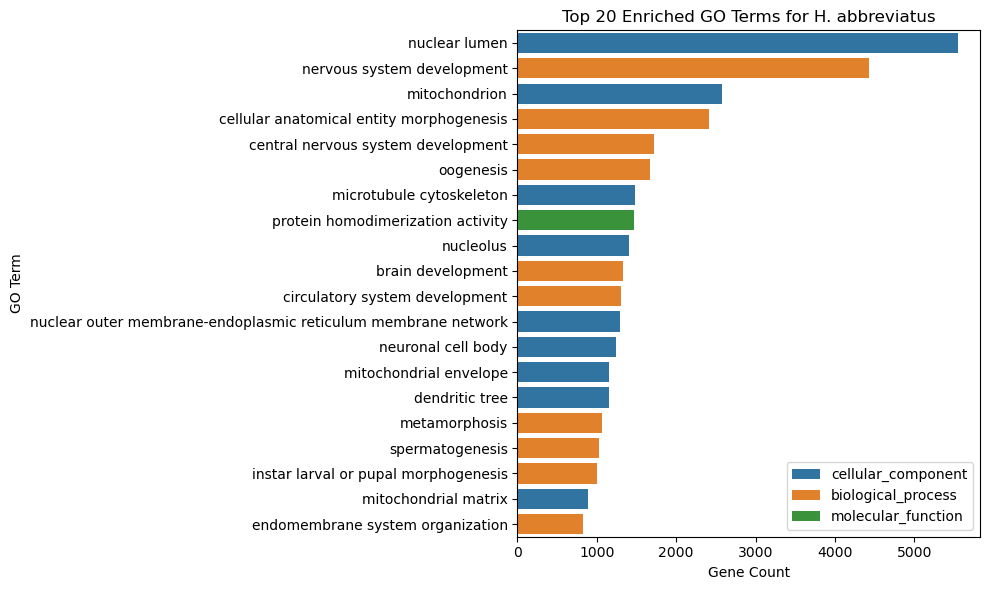

In [38]:
# Visualization Parameters
plt.figure(figsize=(10, 6))
sns.barplot(data=top_terms, y="term_name", x="count", hue="namespace")
plt.xlabel("Gene Count")
plt.ylabel("GO Term")
plt.title("Top 20 Enriched GO Terms for H. abbreviatus")
plt.legend(title="")
plt.tight_layout()
plt.savefig("Habb_GO_Enrichment_NEW.png", dpi=600) # Download the chart
plt.show()

In [39]:
# Visualize top 20 GO Terms for ONLY Biological Process
bp_terms = go_counts_bp.sort_values("count", ascending=False).head(20)

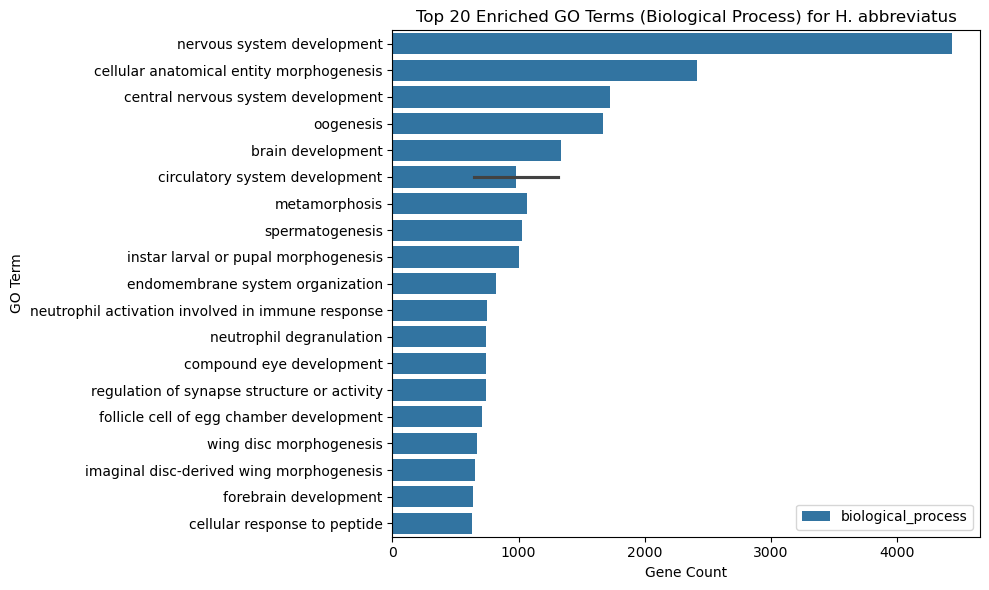

In [40]:
# Visualization parameters
plt.figure(figsize=(10, 6))
sns.barplot(data=bp_terms, y="term_name", x="count", hue="namespace")
plt.xlabel("Gene Count")
plt.ylabel("GO Term")
plt.title("Top 20 Enriched GO Terms (Biological Process) for H. abbreviatus")
plt.legend(title="")
plt.tight_layout()
plt.savefig("Habb_GO_Enrichment_bp_NEW.png", dpi=600)
plt.show()

In [41]:
# Visualize top 20 GO Terms for ONLY Cellular Components
cc_terms = go_counts_cc.sort_values("count", ascending=False).head(20)

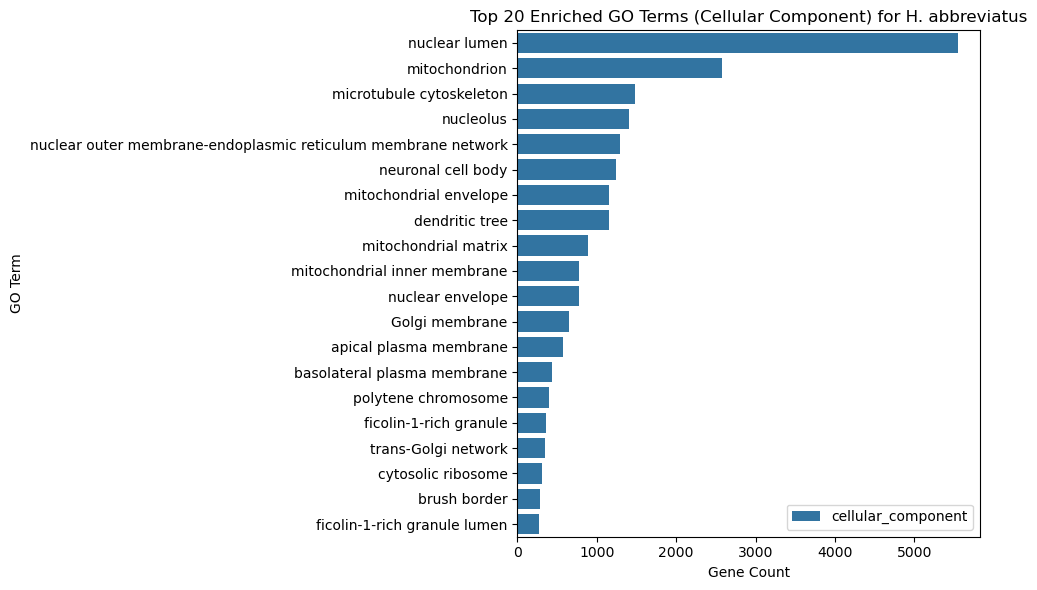

In [42]:
plt.figure(figsize=(10, 6))
sns.barplot(data=cc_terms, y="term_name", x="count", hue="namespace")
plt.xlabel("Gene Count")
plt.ylabel("GO Term")
plt.title("Top 20 Enriched GO Terms (Cellular Component) for H. abbreviatus")
plt.legend(title="")
plt.tight_layout()
plt.savefig("Habb_GO_Enrichment_cc_NEW.png", dpi=600)
plt.show()

In [43]:
# # Visualize top 20 GO Terms for ONLY Molecular Function
mf_terms = go_counts_mf.sort_values("count", ascending=False).head(20)

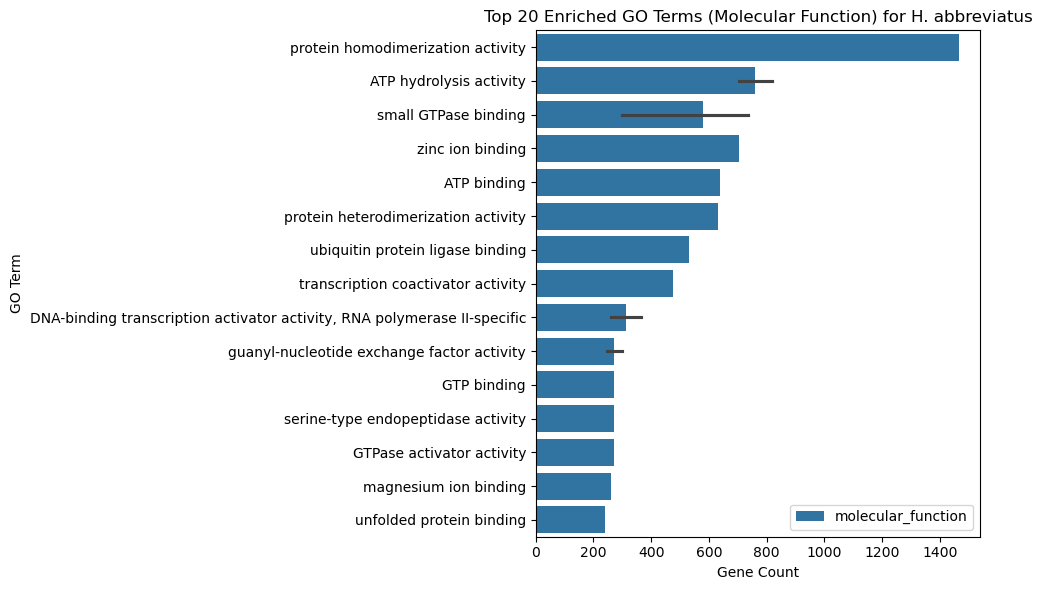

In [44]:
plt.figure(figsize=(10, 6))
sns.barplot(data=mf_terms, y="term_name", x="count", hue="namespace")
plt.xlabel("Gene Count")
plt.ylabel("GO Term")
plt.title("Top 20 Enriched GO Terms (Molecular Function) for H. abbreviatus")
plt.legend(title="")
plt.tight_layout()
plt.savefig("Habb_GO_Enrichment_mf_NEW.png", dpi=600)
plt.show()

In [45]:
# GO Enrichment Visualization: Top 10 for each category

In [46]:
go_counts_filtered.head()

,go_id,term_name,namespace,depth,count
3276,GO:0031981,nuclear lumen,cellular_component,5.0,5551
1649,GO:0007399,nervous system development,biological_process,4.0,4434
1236,GO:0005739,mitochondrion,cellular_component,5.0,2582
3485,GO:0032989,cellular anatomical entity morphogenesis,biological_process,4.0,2416
1657,GO:0007417,central nervous system development,biological_process,4.0,1724


In [47]:
import textwrap
import matplotlib.patches as mpatches

In [48]:
# Define GO categories and colors
category_colors = {
    'biological_process': 'red',    # Biological Process
    'molecular_function': 'green',  # Molecular Function
    'cellular_component': 'blue'    # Cellular Component
}

In [49]:
# Assign colors based on category
go_counts_filtered['color'] = go_counts_filtered['namespace'].map(category_colors)

C:\Users\Staff\AppData\Local\Temp\ipykernel_8428\592195427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  go_counts_filtered['color'] = go_counts_filtered['namespace'].map(category_colors)


In [50]:
# Get top 10 for each category (BP, CC, MF)
top_bp = go_counts_filtered[go_counts_filtered['namespace'] == 'biological_process'].nlargest(10, 'count')
top_cc = go_counts_filtered[go_counts_filtered['namespace'] == 'cellular_component'].nlargest(10, 'count')
top_mf = go_counts_filtered[go_counts_filtered['namespace'] == 'molecular_function'].nlargest(10, 'count')

In [51]:
# Combine top GO terms from each category
df_top = pd.concat([top_bp, top_cc, top_mf])

In [52]:
df_top.head(2)

,go_id,term_name,namespace,depth,count,color
1649,GO:0007399,nervous system development,biological_process,4.0,4434,red
3485,GO:0032989,cellular anatomical entity morphogenesis,biological_process,4.0,2416,red


In [53]:
# Wrap long text labels (GO term names)
df_top['term_name'] = df_top['term_name'].apply(lambda x: '\n'.join(textwrap.wrap(x, width=65)))

In [54]:
import numpy as np

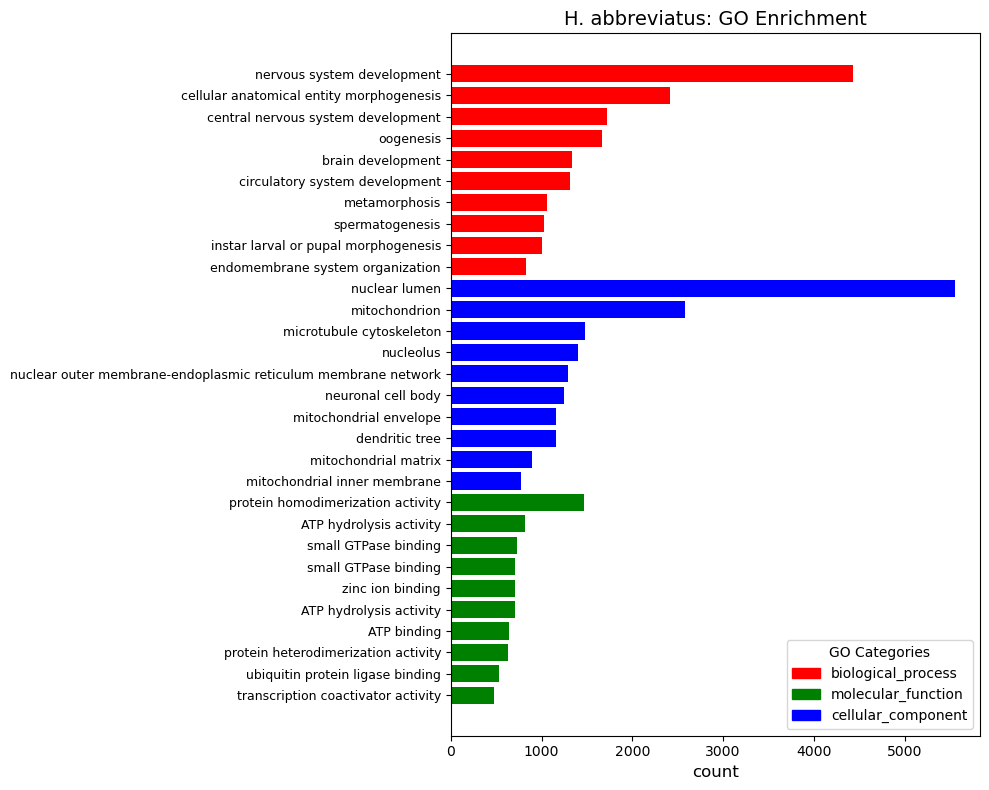

In [55]:
# Plot settings
plt.figure(figsize=(10, 8))
y_pos = np.arange(len(df_top))

# Create bar plot
plt.barh(y_pos, df_top['count'], color=df_top['color'], align='center')

# Labels and formatting
plt.yticks(y_pos, df_top['term_name'], fontsize=9)
plt.xlabel('count', fontsize=12)
plt.title('H. abbreviatus: GO Enrichment', fontsize=14)
plt.gca().invert_yaxis()

# Add legend
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in category_colors.items()]
plt.legend(handles=legend_patches, title="GO Categories")

# Save and show
plt.tight_layout()
plt.savefig("go_enrichment_Habb_ALL_PROCESSES.png", dpi=600)
plt.show()